# Code used to test the produced cGAN


In [1]:
! pip3 install rasterio

     |████████████████████████████████| 18.0MB 222kB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from google.colab import drive
from google.colab import files
import sys
from PIL import Image
import rasterio

TensorFlow 2.x selected.


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Input image = satellite, Real Image = DEM
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]


# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

def load_image_test(input_image, real_image):
    real_image = tf.image.grayscale_to_rgb(real_image)
    #input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	return [X1, X2]

In [6]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/ImageToDEM/'
sys.path.append(path)
# load image data
dataset = load_real_samples(path + 'DataAll/TestRiversRGB.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
dataset[0] = tf.cast(dataset[0],tf.float32)
dataset[1] = tf.cast(dataset[1],tf.float32)

test_dataset = tf.data.Dataset.from_tensor_slices((dataset[0][:20], dataset[1][:20]))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded (2, 256, 256, 3) (2, 256, 256, 1)


In [0]:
def generate_images(model, test_input, tar=tf.zeros([0,0])):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))
  if(tf.size(tar) > 0):
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
  else:
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
  for i in range(len(title)):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    if(display_list[i].shape[2] == 1):
      display_list[i] = tf.image.grayscale_to_rgb(display_list[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  if(not tf.size(tar) > 0):
    return prediction 

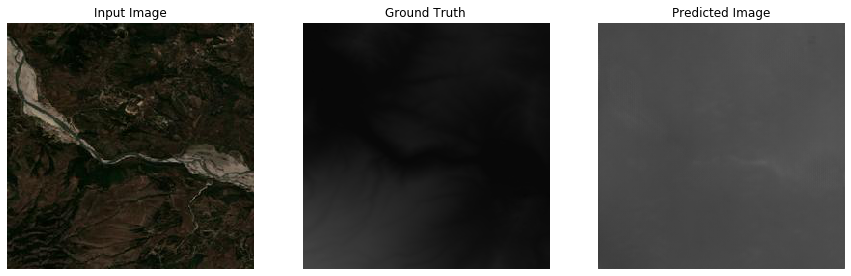

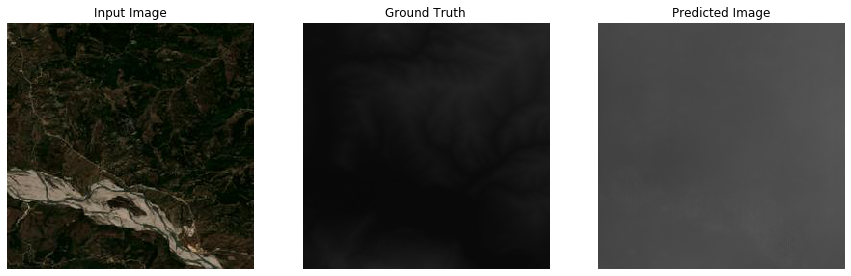

In [8]:
generator = tf.saved_model.load('/content/drive/My Drive/ImageToDEM/ncGAN/models')
# Run the trained model on the entire test dataset
for inp, tar in test_dataset:
  generate_images(generator, inp, tar)

In [9]:
dataset1 = load_real_samples(path + 'DataAll/TrainAllRGB.npz')


KeyboardInterrupt: ignored

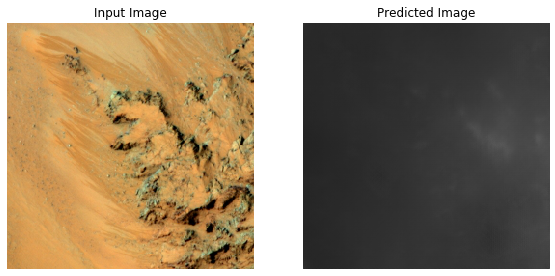

(256, 256)


In [10]:
def denormalize(arr, oldMin, oldMax, newMin, newMax):
	minn = oldMin
	maxx = oldMax
	arr = (newMax - newMin) * (arr - minn)/(maxx - minn) + newMin
	return arr.astype('int16', copy=False)

def saveDEM(cpPath, path, temp, arr, name):
    outname = name[:-4] + ".tif"
    ! cp {cpPath + temp} {cpPath+outname}
    with rasterio.open(path + temp, 'r+') as ds:
    	ds.write(arr.reshape((1,SIZE,SIZE)))

SIZE = 256
path = '/content/drive/My Drive/ImageToDEM/'
tempDEM = 'temp.tif'
inn = 'test5.jpg'
image = np.asarray(Image.open(path + inn))
# image = np.asarray(dataset1[0][8])
# sdf = image.astype(np.uint8)
# import matplotlib

# matplotlib.image.imsave(path + 'name.jpg', sdf)

image = (image / 127.5) - 1
image = tf.cast(image,tf.float32)
image = tf.expand_dims(image, 0)
prediction = generate_images(generator, image)
prediction = tf.squeeze(prediction)
print(prediction.shape)
out = prediction.numpy()
out = (1+out)/2
out = denormalize(out, 0, 1, 0, 255)
cpPath = '/content/drive/My\ Drive/ImageToDEM/'
saveDEM(cpPath, path, tempDEM, out, inn)
